In [1]:
%run Imports.ipynb
from quantpy.tomography.interval import ConfidenceInterval, _pop_hidden_keys, Mode

import numpy as np
import scipy.linalg as la
import scipy.stats as sts
import polytope as pc
import math
import pypoman

from enum import Enum, auto
from abc import ABC, abstractmethod
from scipy.interpolate import interp1d
from collections import Counter, defaultdict
from functools import partial
from cvxopt import matrix, solvers
from einops import repeat, rearrange
from matplotlib.lines import Line2D

from quantpy.geometry import hs_dst, trace_dst, if_dst
from quantpy.polytope import compute_polytope_volume, find_max_distance_to_polytope
from quantpy.qobj import Qobj
from quantpy.routines import (
    _left_inv, _vec2mat, _mat2vec,
    _matrix_to_real_tril_vec, _real_tril_vec_to_matrix,
)
from quantpy.measurements import generate_measurement_matrix

In [2]:
titlesize = 40
labelsize = 66
legendsize = 46
xticksize = 48
yticksize = xticksize
linewidth = 3
fontsize = 60
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize
matplotlib.rcParams['font.size'] = fontsize
matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)

In [3]:
def count_confidence(delta, frequencies, n_measurements):
    EPS = 1e-15
    freq_plus_delta = np.clip(frequencies + delta, EPS, 1 - EPS)
    KL_divergence = (frequencies * np.log(frequencies / freq_plus_delta)
                     + (1 - frequencies) * np.log(
                (1 - frequencies) / (1 - freq_plus_delta)))
    KL_divergence = np.where(freq_plus_delta < 1 - EPS, KL_divergence, np.inf)
    epsilons = np.exp(-n_measurements[:, None] * KL_divergence)
    epsilons = np.where(np.abs(frequencies - 1) < 2 * EPS, 0, epsilons)
    return np.prod(np.maximum(1 - np.sum(epsilons, axis=-1), 0))

def count_delta(target_cl, frequencies, n_measurements):
    EPS = 1e-10
    left = 1e-10
    right = 1
    while right - left > 1e-10:
        delta = (left + right) / 2
        confidence = count_confidence(delta, frequencies, n_measurements)
        if confidence < target_cl + EPS:
            left = delta
        else:
            right = delta
    return delta

## States

In [4]:
class WangIntervalFidelity(ConfidenceInterval):    
    def __init__(self, tmg, n_points=1000, target_state=None):
        kwargs = _pop_hidden_keys(locals())
        super().__init__(tmg, **kwargs)
        
    def __call__(self, conf_levels=None):
        if conf_levels is None:
            conf_levels = np.linspace(1e-3, 1-1e-3, 1000)
        if not hasattr(self, 'cl_to_dist_max'):
            self.setup()
        return (self.cl_to_dist_min(conf_levels), self.cl_to_dist_max(conf_levels)), conf_levels

    def setup(self):
        if self.mode == Mode.CHANNEL:
            raise NotImplementedError("This interval works only for state tomography")
            
        if self.target_state is None:
            self.target_state = self.tmg.state
        
        dim = 2 ** self.tmg.state.n_qubits
        frequencies = np.clip(self.tmg.raw_results / self.tmg.n_measurements[:, None], self.EPS, 1 - self.EPS)

        povm_matrix = (np.reshape(self.tmg.povm_matrix * self.tmg.n_measurements[:, None, None]
                                  / np.sum(self.tmg.n_measurements),
                                  (-1, self.tmg.povm_matrix.shape[-1]))
                       * self.tmg.povm_matrix.shape[0])
        A = np.ascontiguousarray(povm_matrix[:, 1:]) * dim
        
        max_delta = count_delta(1-1e-5, frequencies, self.tmg.n_measurements)
        min_delta = count_delta(0, frequencies, self.tmg.n_measurements)
        deltas = np.linspace(min_delta, max_delta, self.n_points)
        
        dist_max = []
        dist_min = []
        for delta in tqdm(deltas):
            b = np.clip(np.hstack(frequencies) + delta, self.EPS, 1 - self.EPS) - povm_matrix[:, 0]
            c = matrix(self.target_state.bloch[1:])
            G, h = matrix(A), matrix(b)
            sol = solvers.lp(c, G, h)
            if not sol['primal objective']:
                dist_min.append(1)
            else:
                dist_min.append(1/dim + sol['primal objective'] * dim)
            sol = solvers.lp(-c, G, h)
            if not sol['primal objective']:
                dist_max.append(1)
            else:
                dist_max.append(1/dim - sol['primal objective'] * dim)
        
        conf_levels = []
        for delta in deltas:
            conf_levels.append(count_confidence(delta, frequencies, self.tmg.n_measurements))
        self.cl_to_dist_max = interp1d(conf_levels, dist_max)
        self.cl_to_dist_min = interp1d(conf_levels, dist_min)

In [5]:
n = 2
target_state = qp.qobj.GHZ(n)
dep_channel = qp.channel.depolarizing(0.05, n)
state = dep_channel.transform(target_state)

tmg = qp.StateTomograph(state)
tmg.experiment(10000)
state_hat = tmg.point_estimate()
fidelity = 1 - qp.if_dst(target_state, state)
interval = WangIntervalFidelity(tmg, target_state=target_state)
(dist_min, dist_max), conf_levels = interval()
epsilons = 1 - conf_levels

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.02, 0.9, 'a)')

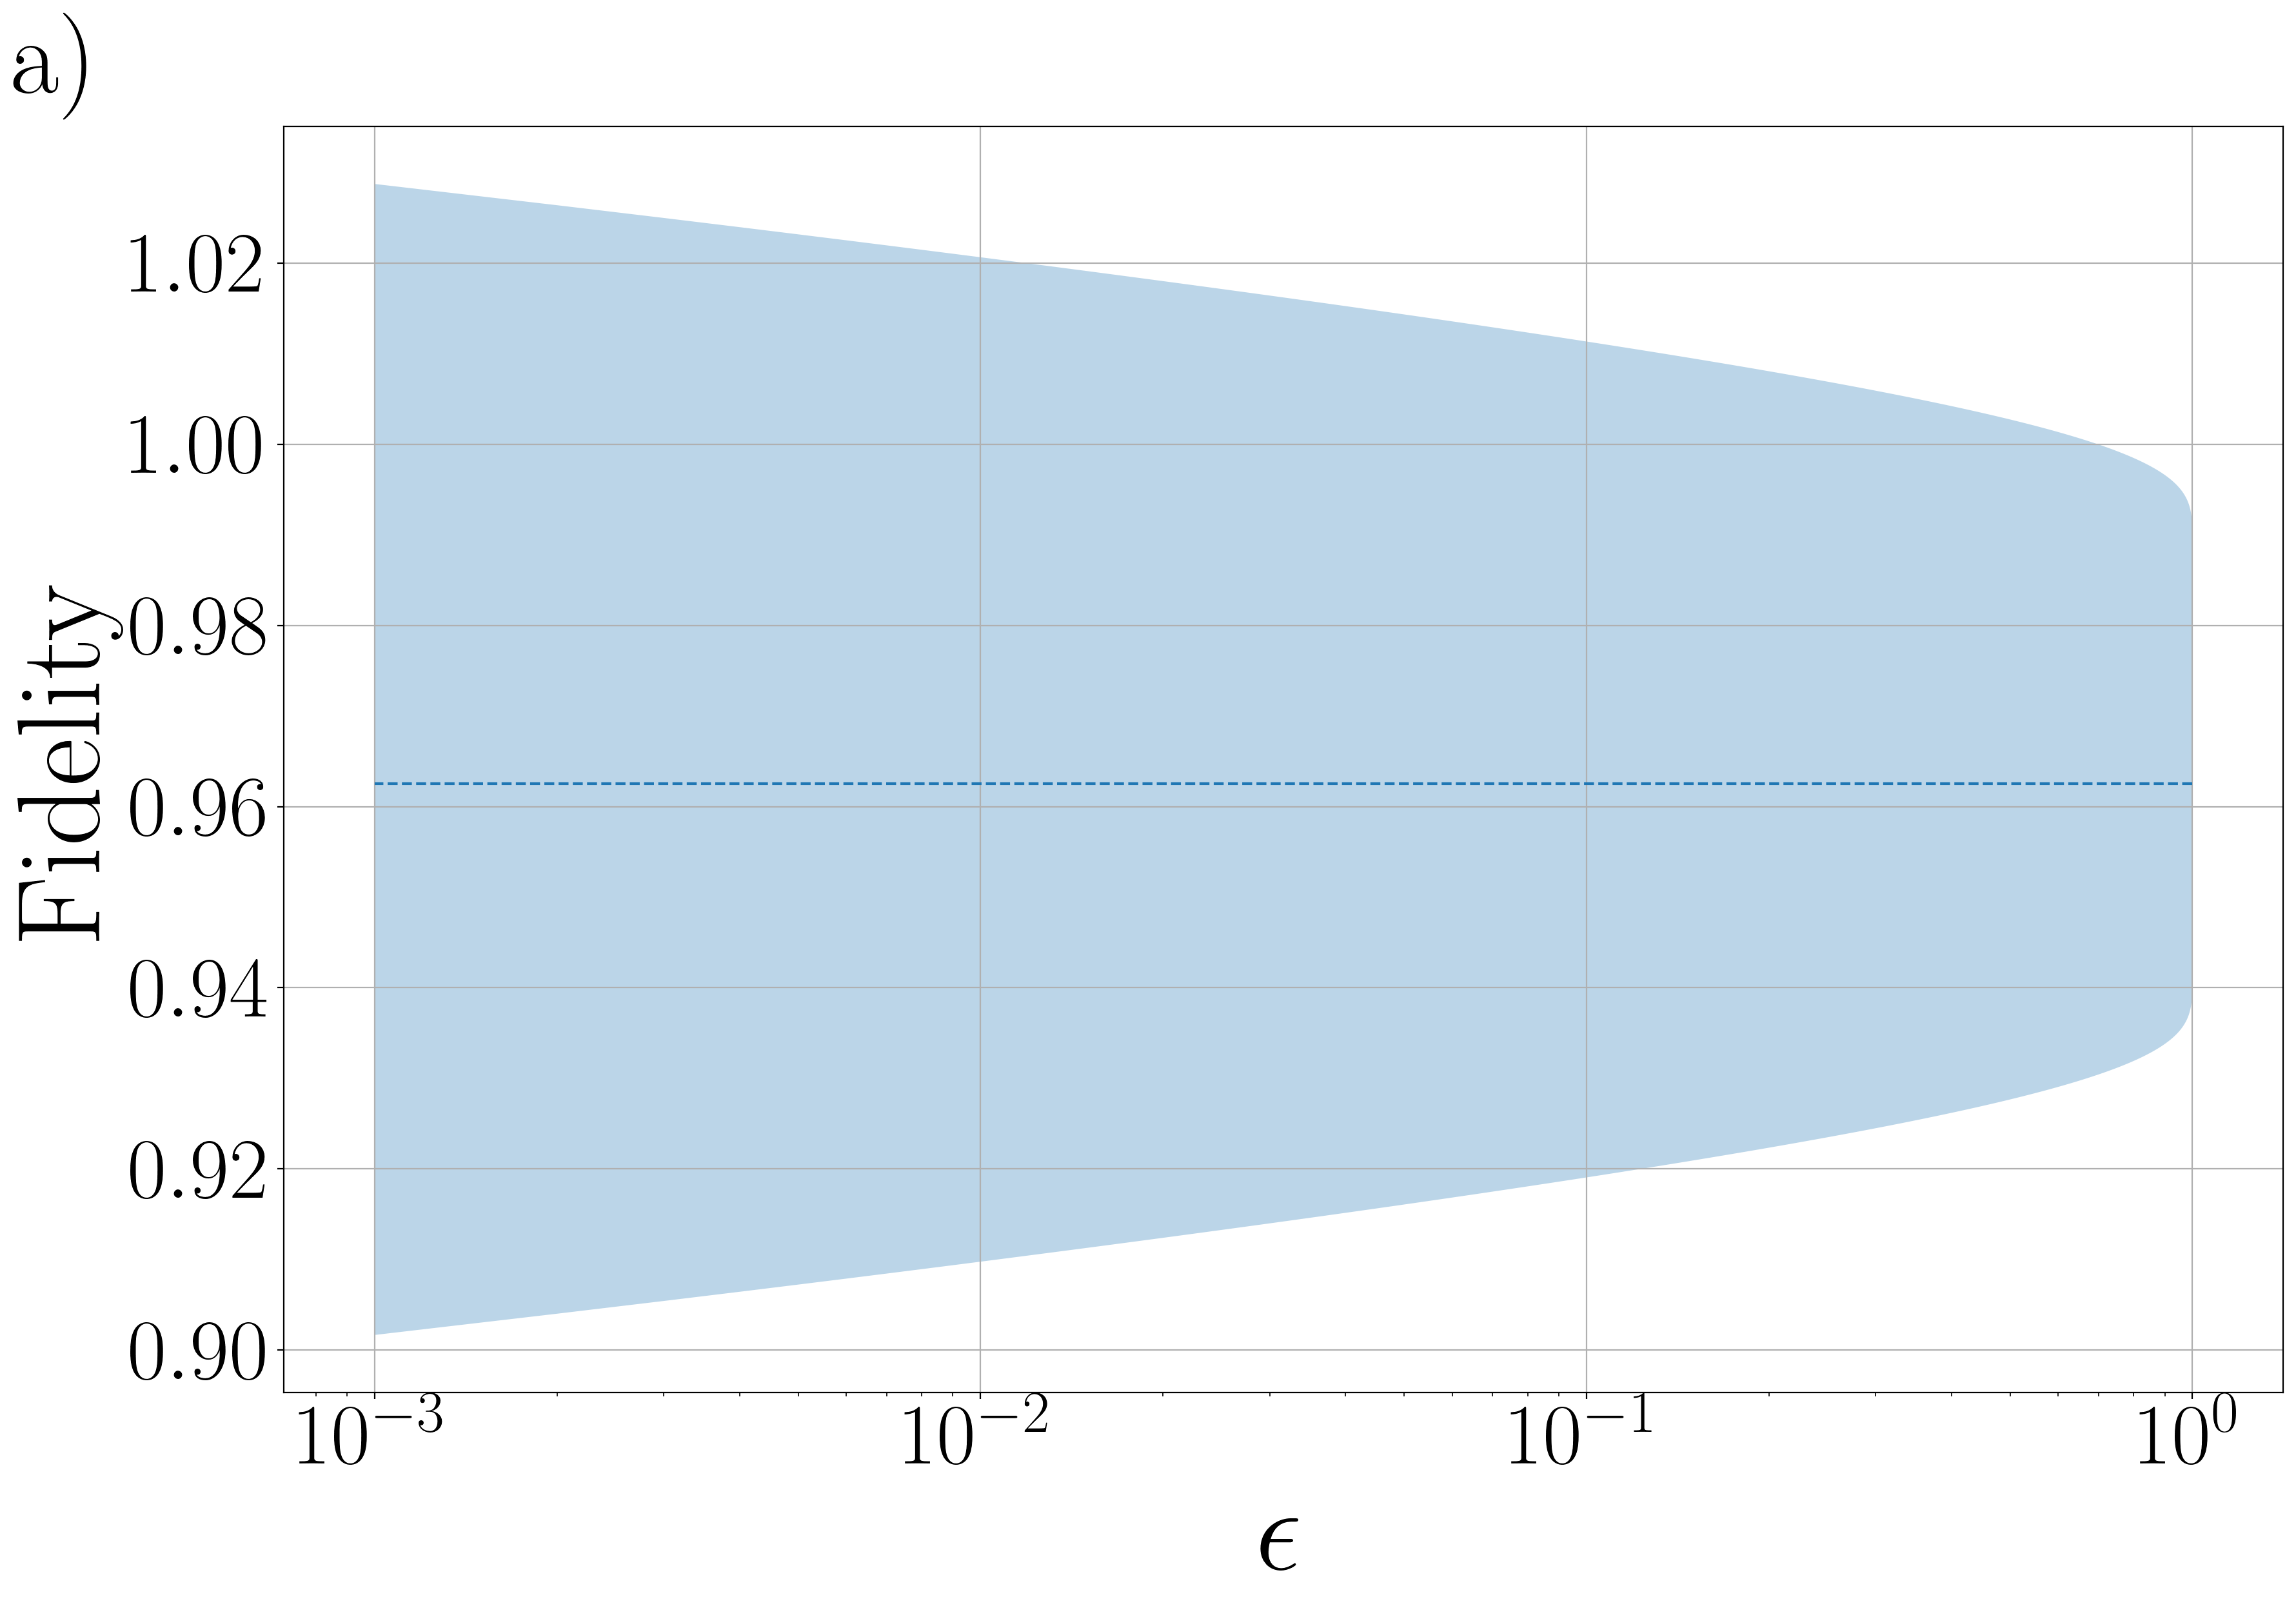

In [6]:
plt.figure(figsize=(20, 13), dpi=200)
plt.xlabel('$\\epsilon$')
plt.ylabel('Fidelity')
plt.grid()
plt.fill_between(epsilons, dist_min, dist_max, alpha=0.3)
plt.xscale('log')
plt.plot([epsilons[0], epsilons[-1]], [fidelity] * 2, '--')
plt.figtext(0.02, 0.9, "a)")

## Processes

In [13]:
class ProcessWangIntervalFidelity(ConfidenceInterval):
    def __init__(self, tmg, n_points=1000, target_channel=None):
        kwargs = _pop_hidden_keys(locals())
        super().__init__(tmg, **kwargs)
        
    def __call__(self, conf_levels=None):
        if conf_levels is None:
            conf_levels = np.linspace(1e-3, 1-1e-3, 1000)
        if not hasattr(self, 'cl_to_dist_max'):
            self.setup()
        return (self.cl_to_dist_min(conf_levels), self.cl_to_dist_max(conf_levels)), conf_levels
        
    def setup(self):
        channel = self.tmg.channel
        dim_in = dim_out = 2 ** channel.n_qubits
        dim = dim_in * dim_out
        bloch_indices = [i for i in range(dim ** 2) if i % (dim_out ** 2) != 0]
        
        if self.target_channel is None:
            self.target_channel = channel
        
        povm_matrix = self.tmg.tomographs[0].povm_matrix
        n_measurements = self.tmg.tomographs[0].n_measurements

        frequencies = np.asarray([
            np.clip(tmg.raw_results / tmg.n_measurements[:, None], self.EPS, 1 - self.EPS)
            for tmg in self.tmg.tomographs
        ])
        
        meas_matrix = (np.reshape(povm_matrix * n_measurements[:, None, None] / np.sum(n_measurements),
                                  (-1, povm_matrix.shape[-1])) 
                       * povm_matrix.shape[0])
        states_matrix = np.asarray([rho.T.bloch for rho in self.tmg.input_basis.elements])
        channel_matrix = np.einsum("i a, j b -> i j a b", states_matrix, meas_matrix[:, 1:]) * dim
        channel_matrix = rearrange(channel_matrix, "i j a b -> (i j) (a b)")
        A = np.ascontiguousarray(channel_matrix)
        
        max_delta = count_delta(1-1e-5, frequencies, n_measurements)
        min_delta = count_delta(0, frequencies, n_measurements)
        deltas = np.linspace(min_delta, max_delta, self.n_points)
        
        dist_max = []
        dist_min = []
        for delta in deltas:
            b = (np.hstack(np.concatenate(frequencies, axis=0)) + delta 
                 - repeat(meas_matrix[:, 0], 'a -> (b a)', b=len(states_matrix)))
            c = matrix(self.target_channel.choi.bloch[bloch_indices])
            G, h = matrix(A), matrix(b)
            sol = solvers.lp(c, G, h)
            if not sol['primal objective']:
                dist_min.append(1)
            else:
                dist_min.append(1/dim + sol['primal objective'])
            sol = solvers.lp(-c, G, h)
            if not sol['primal objective']:
                dist_max.append(1)
            else:
                dist_max.append(1/dim - sol['primal objective'])

        conf_levels = []
        for delta in deltas:
            conf_levels.append(count_confidence(delta, frequencies, self.tmg.tomographs[0].n_measurements))
        self.cl_to_dist_max = interp1d(conf_levels, dist_max)
        self.cl_to_dist_min = interp1d(conf_levels, dist_min)

In [15]:
target_channel = qp.channel.depolarizing(0, 1)
channel = qp.channel.depolarizing(0.05, 1)

dim = 4 ** channel.n_qubits
tmg = qp.ProcessTomograph(channel, input_states='proj4')
tmg.experiment(100)
channel_hat = tmg.point_estimate()
fidelity = np.dot(target_channel.choi.bloch, channel.choi.bloch)
interval = ProcessWangIntervalFidelity(tmg, target_channel=target_channel)
(dist_min, dist_max), conf_levels = interval()
epsilons = 1 - conf_levels

Text(0.02, 0.9, 'a)')

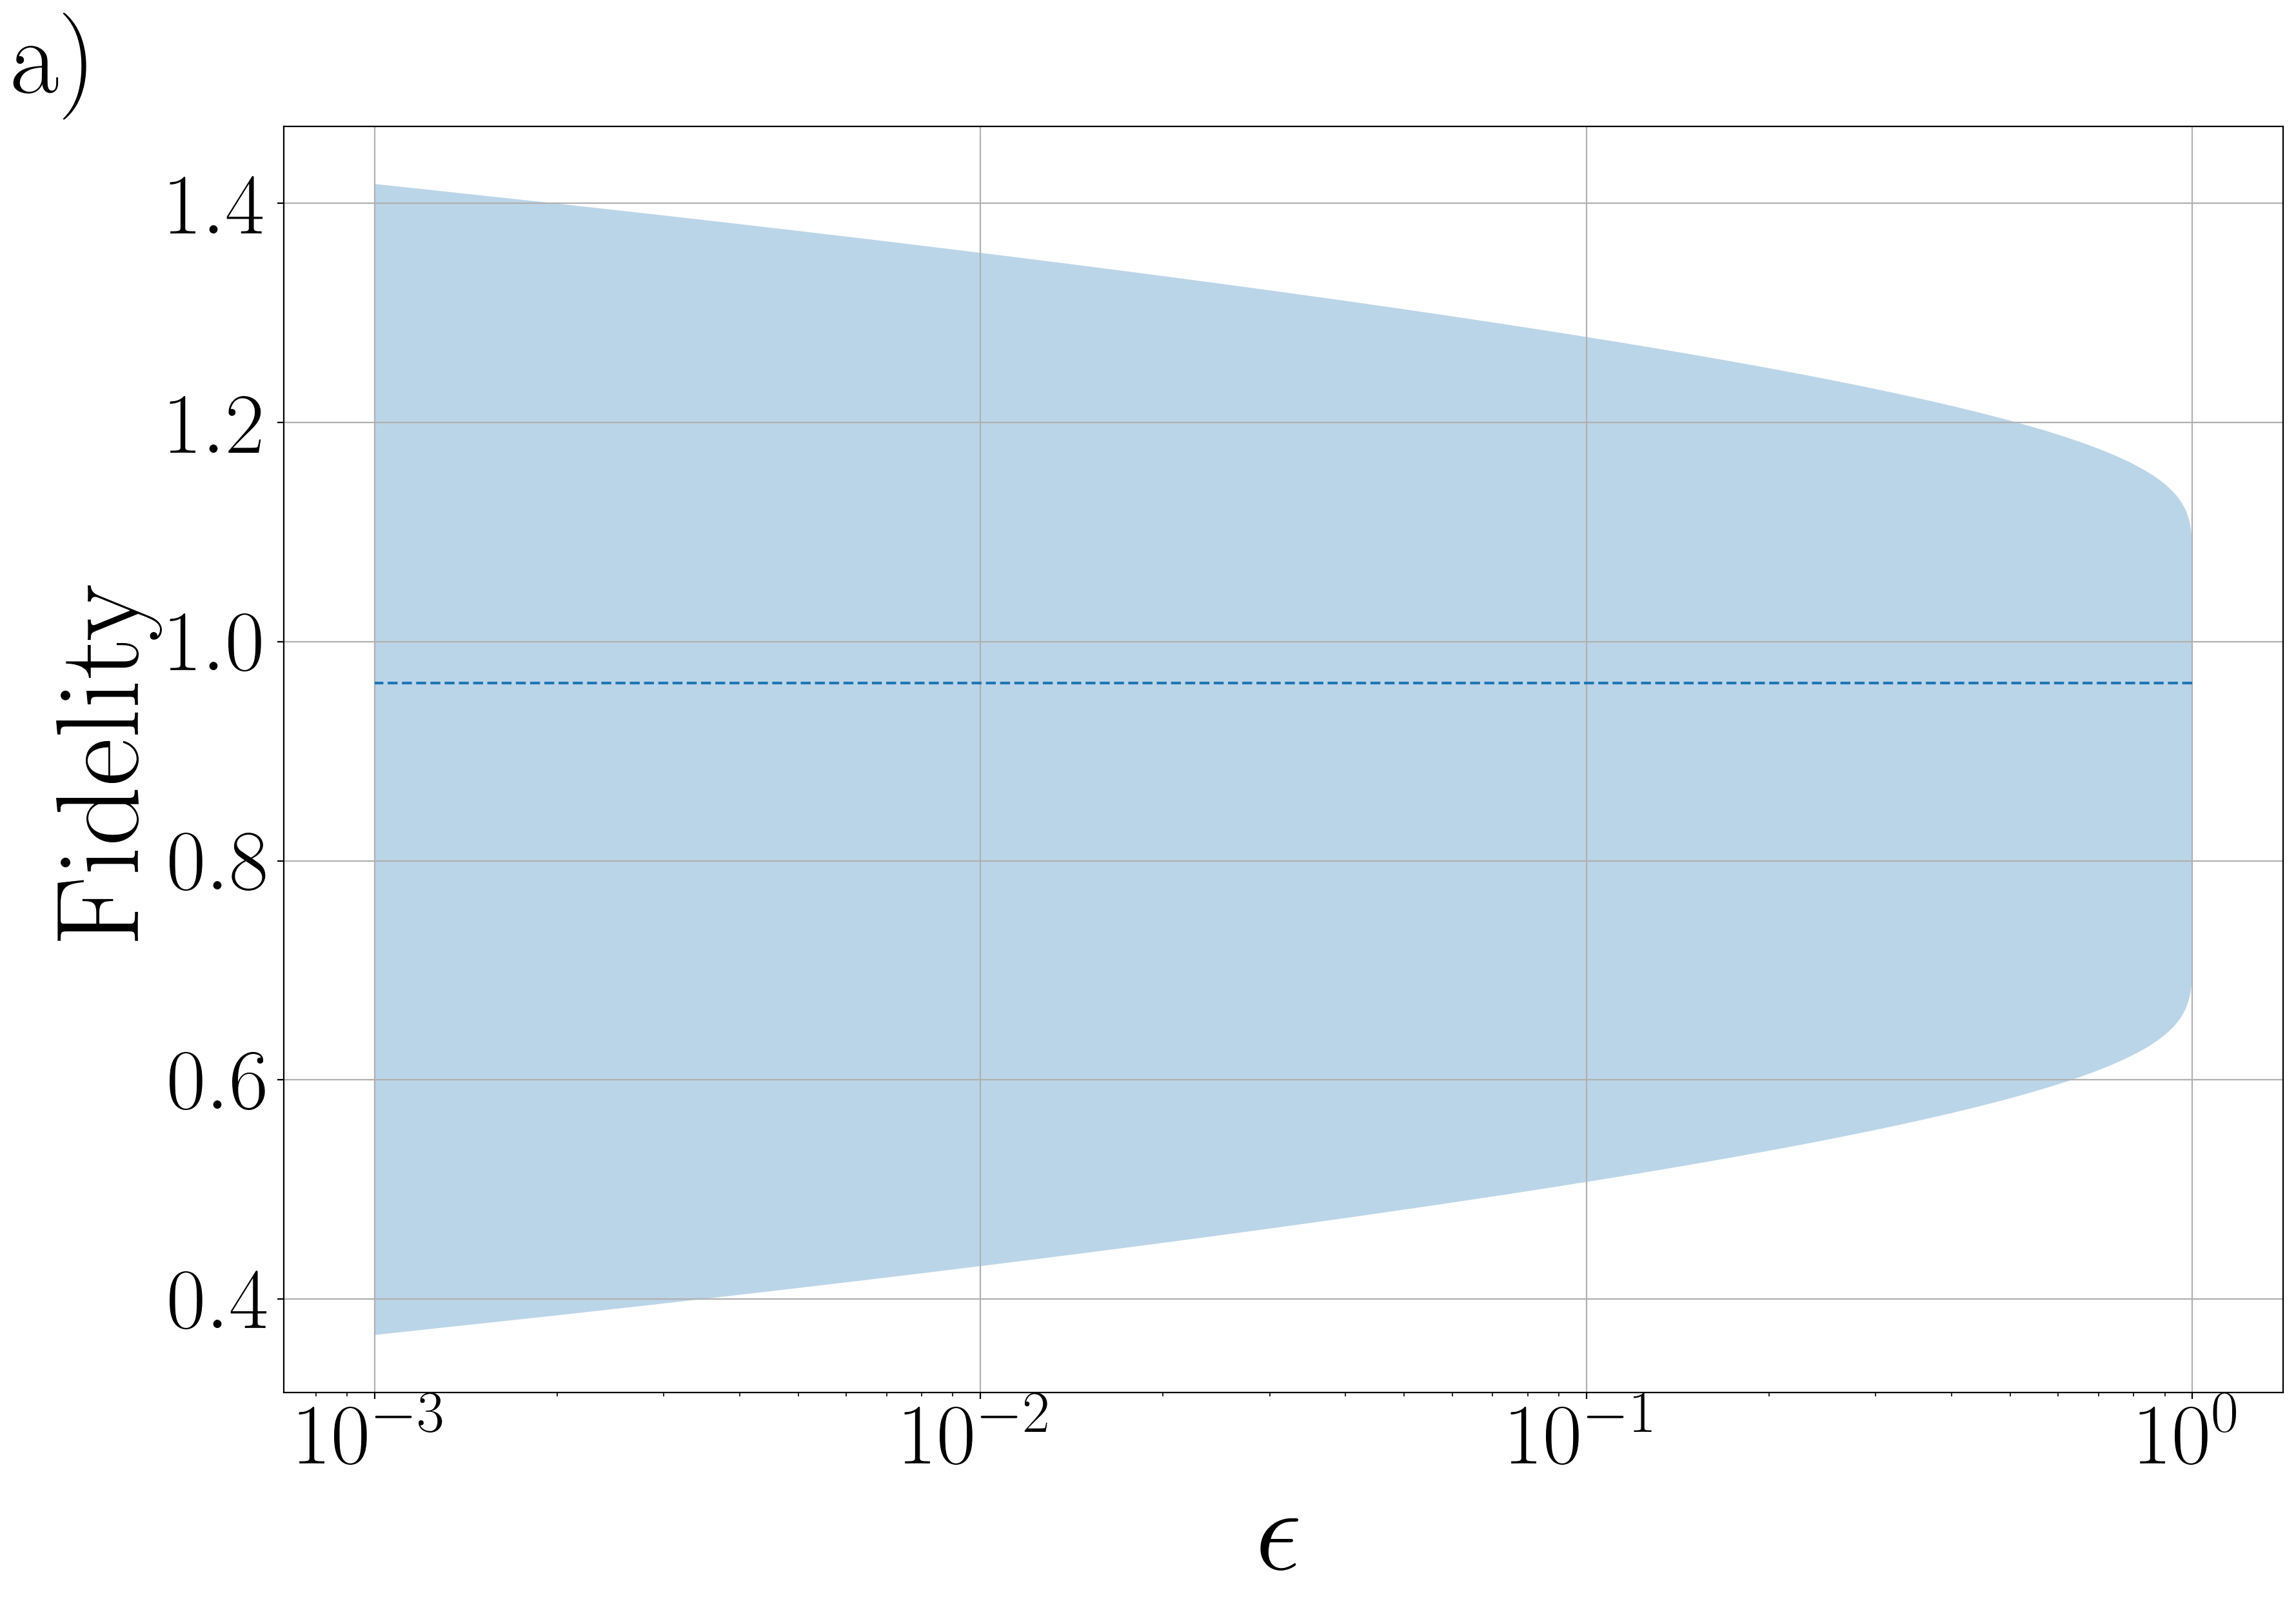

In [16]:
plt.figure(figsize=(20, 13), dpi=200)
plt.xlabel('$\\epsilon$')
plt.ylabel('Fidelity')
plt.grid()
plt.fill_between(epsilons, dist_min, dist_max, alpha=0.3)
plt.xscale('log')
plt.plot([epsilons[0], epsilons[-1]], [fidelity] * 2, '--')
plt.figtext(0.02, 0.9, "a)")

## Sandbox

In [32]:
target_channel = qp.channel.depolarizing(0, 1)
channel = qp.channel.depolarizing(0.1, 1)

dim = 4 ** channel.n_qubits
n_measurements = 10 ** 4
tmg = qp.ProcessTomograph(channel, input_states='sic')
tmg.experiment(n_measurements)
channel_hat = tmg.point_estimate()
true_fidelity = np.dot(target_channel.choi.bloch, channel.choi.bloch)
EPS = 1e-15
bloch_indices = [i for i in range(dim ** 2) if i % dim != 0]

povm_matrix = tmg.tomographs[0].povm_matrix
n_measurements = tmg.tomographs[0].n_measurements

meas_matrix = (np.reshape(povm_matrix * n_measurements[:, None, None] / np.sum(n_measurements),
                          (-1, povm_matrix.shape[-1])) 
               * povm_matrix.shape[0])
states_matrix = np.asarray([rho.T.bloch for rho in tmg.input_basis.elements])
channel_matrix = np.einsum("i a, j b -> i j a b", states_matrix, meas_matrix[:, 1:]) * dim
channel_matrix = rearrange(channel_matrix, "i j a b -> (i j) (a b)")
A = np.ascontiguousarray(channel_matrix)

n_trials = 100
epsilons = list(np.logspace(-5, -1, 5)) + [0.99]

min_fidelity = defaultdict(list)
max_fidelity = defaultdict(list)
for _ in tqdm(range(n_trials)):
    tmg = qp.ProcessTomograph(channel, input_states='sic')
    tmg.experiment(n_measurements)
    channel_hat = tmg.point_estimate('lifp')
    frequencies = np.asarray([
        np.clip(ptmg.raw_results / ptmg.n_measurements[:, None], EPS, 1 - EPS)
        for ptmg in tmg.tomographs
    ])
    for i, epsilon in enumerate(epsilons):
        delta = count_delta(1 - epsilon, frequencies, tmg.tomographs[0].n_measurements)
        b = (np.hstack(np.concatenate(frequencies, axis=0)) + delta 
             - repeat(meas_matrix[:, 0], 'a -> (a b)', b=len(states_matrix)))
        c = matrix(target_channel.choi.bloch[bloch_indices])
        G, h = matrix(A), matrix(b)
        sol = solvers.lp(c, G, h)
        min_fidelity[epsilon].append(1/dim + sol['primal objective'])
        sol = solvers.lp(-c, G, h)
        max_fidelity[epsilon].append(1/dim - sol['primal objective'])

  0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
target_channel = qp.channel.depolarizing(0, 1)
channel = qp.channel.depolarizing(0.1, 1)
true_fidelity = np.dot(target_channel.choi.bloch, channel.choi.bloch)
EPS = 1e-15

dim = 4 ** channel.n_qubits
n_meas_list = np.logspace(3, 5, 3)
min_results = []
max_results = []
for n_measurements in n_meas_list:
    n_measurements = int(n_measurements)
    tmg = qp.ProcessTomograph(channel, input_states='sic')
    tmg.experiment(n_measurements)
    bloch_indices = [i for i in range(dim ** 2) if i % dim != 0]

    povm_matrix = tmg.tomographs[0].povm_matrix
    n_measurements = tmg.tomographs[0].n_measurements

    meas_matrix = (np.reshape(povm_matrix * n_measurements[:, None, None] / np.sum(n_measurements),
                              (-1, povm_matrix.shape[-1])) 
                   * povm_matrix.shape[0])
    states_matrix = np.asarray([rho.T.bloch for rho in tmg.input_basis.elements])
    channel_matrix = np.einsum("i a, j b -> i j a b", states_matrix, meas_matrix[:, 1:]) * dim
    channel_matrix = rearrange(channel_matrix, "i j a b -> (i j) (a b)")
    A = np.ascontiguousarray(channel_matrix)

    n_trials = 100
    epsilons = list(np.logspace(-5, -0.2, 20)) + list(np.linspace(0.65, 0.99, 10))

    min_fidelity = defaultdict(list)
    max_fidelity = defaultdict(list)
    for _ in tqdm(range(n_trials)):
        tmg = qp.ProcessTomograph(channel, input_states='sic')
        tmg.experiment(n_measurements)
        frequencies = np.asarray([
            np.clip(ptmg.raw_results / ptmg.n_measurements[:, None], EPS, 1 - EPS)
            for ptmg in tmg.tomographs
        ])
        for i, epsilon in enumerate(epsilons):
            delta = count_delta(1 - epsilon, frequencies, tmg.tomographs[0].n_measurements)
            b = (np.hstack(np.concatenate(frequencies, axis=0)) + delta 
                 - repeat(meas_matrix[:, 0], 'a -> (a b)', b=len(states_matrix)))
            c = matrix(target_channel.choi.bloch[bloch_indices])
            G, h = matrix(A), matrix(b)
            sol = solvers.lp(c, G, h)
            min_fidelity[epsilon].append(1/dim + sol['primal objective'])
            sol = solvers.lp(-c, G, h)
            max_fidelity[epsilon].append(1/dim - sol['primal objective'])
    min_results.append(min_fidelity)
    max_results.append(max_fidelity)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
# legend_elements = [
#     Line2D([0], [0], color='w', marker='o', markerfacecolor='b', label='$n=10^3$'),
#     Line2D([0], [0], color='w', marker='o', markerfacecolor='g', label='$n=10^4$'),
#     Line2D([0], [0], color='w', marker='o', markerfacecolor='r', label='$n=10^5$'),
# ]

legend_elements = [
    Line2D([0], [0], color='b', lw=2, label='$n=10^3$'),
    Line2D([0], [0], color='g', lw=2, label='$n=10^4$'),
    Line2D([0], [0], color='r', lw=2, label='$n=10^5$'),
]

Text(0.02, 0.9, 'a)')

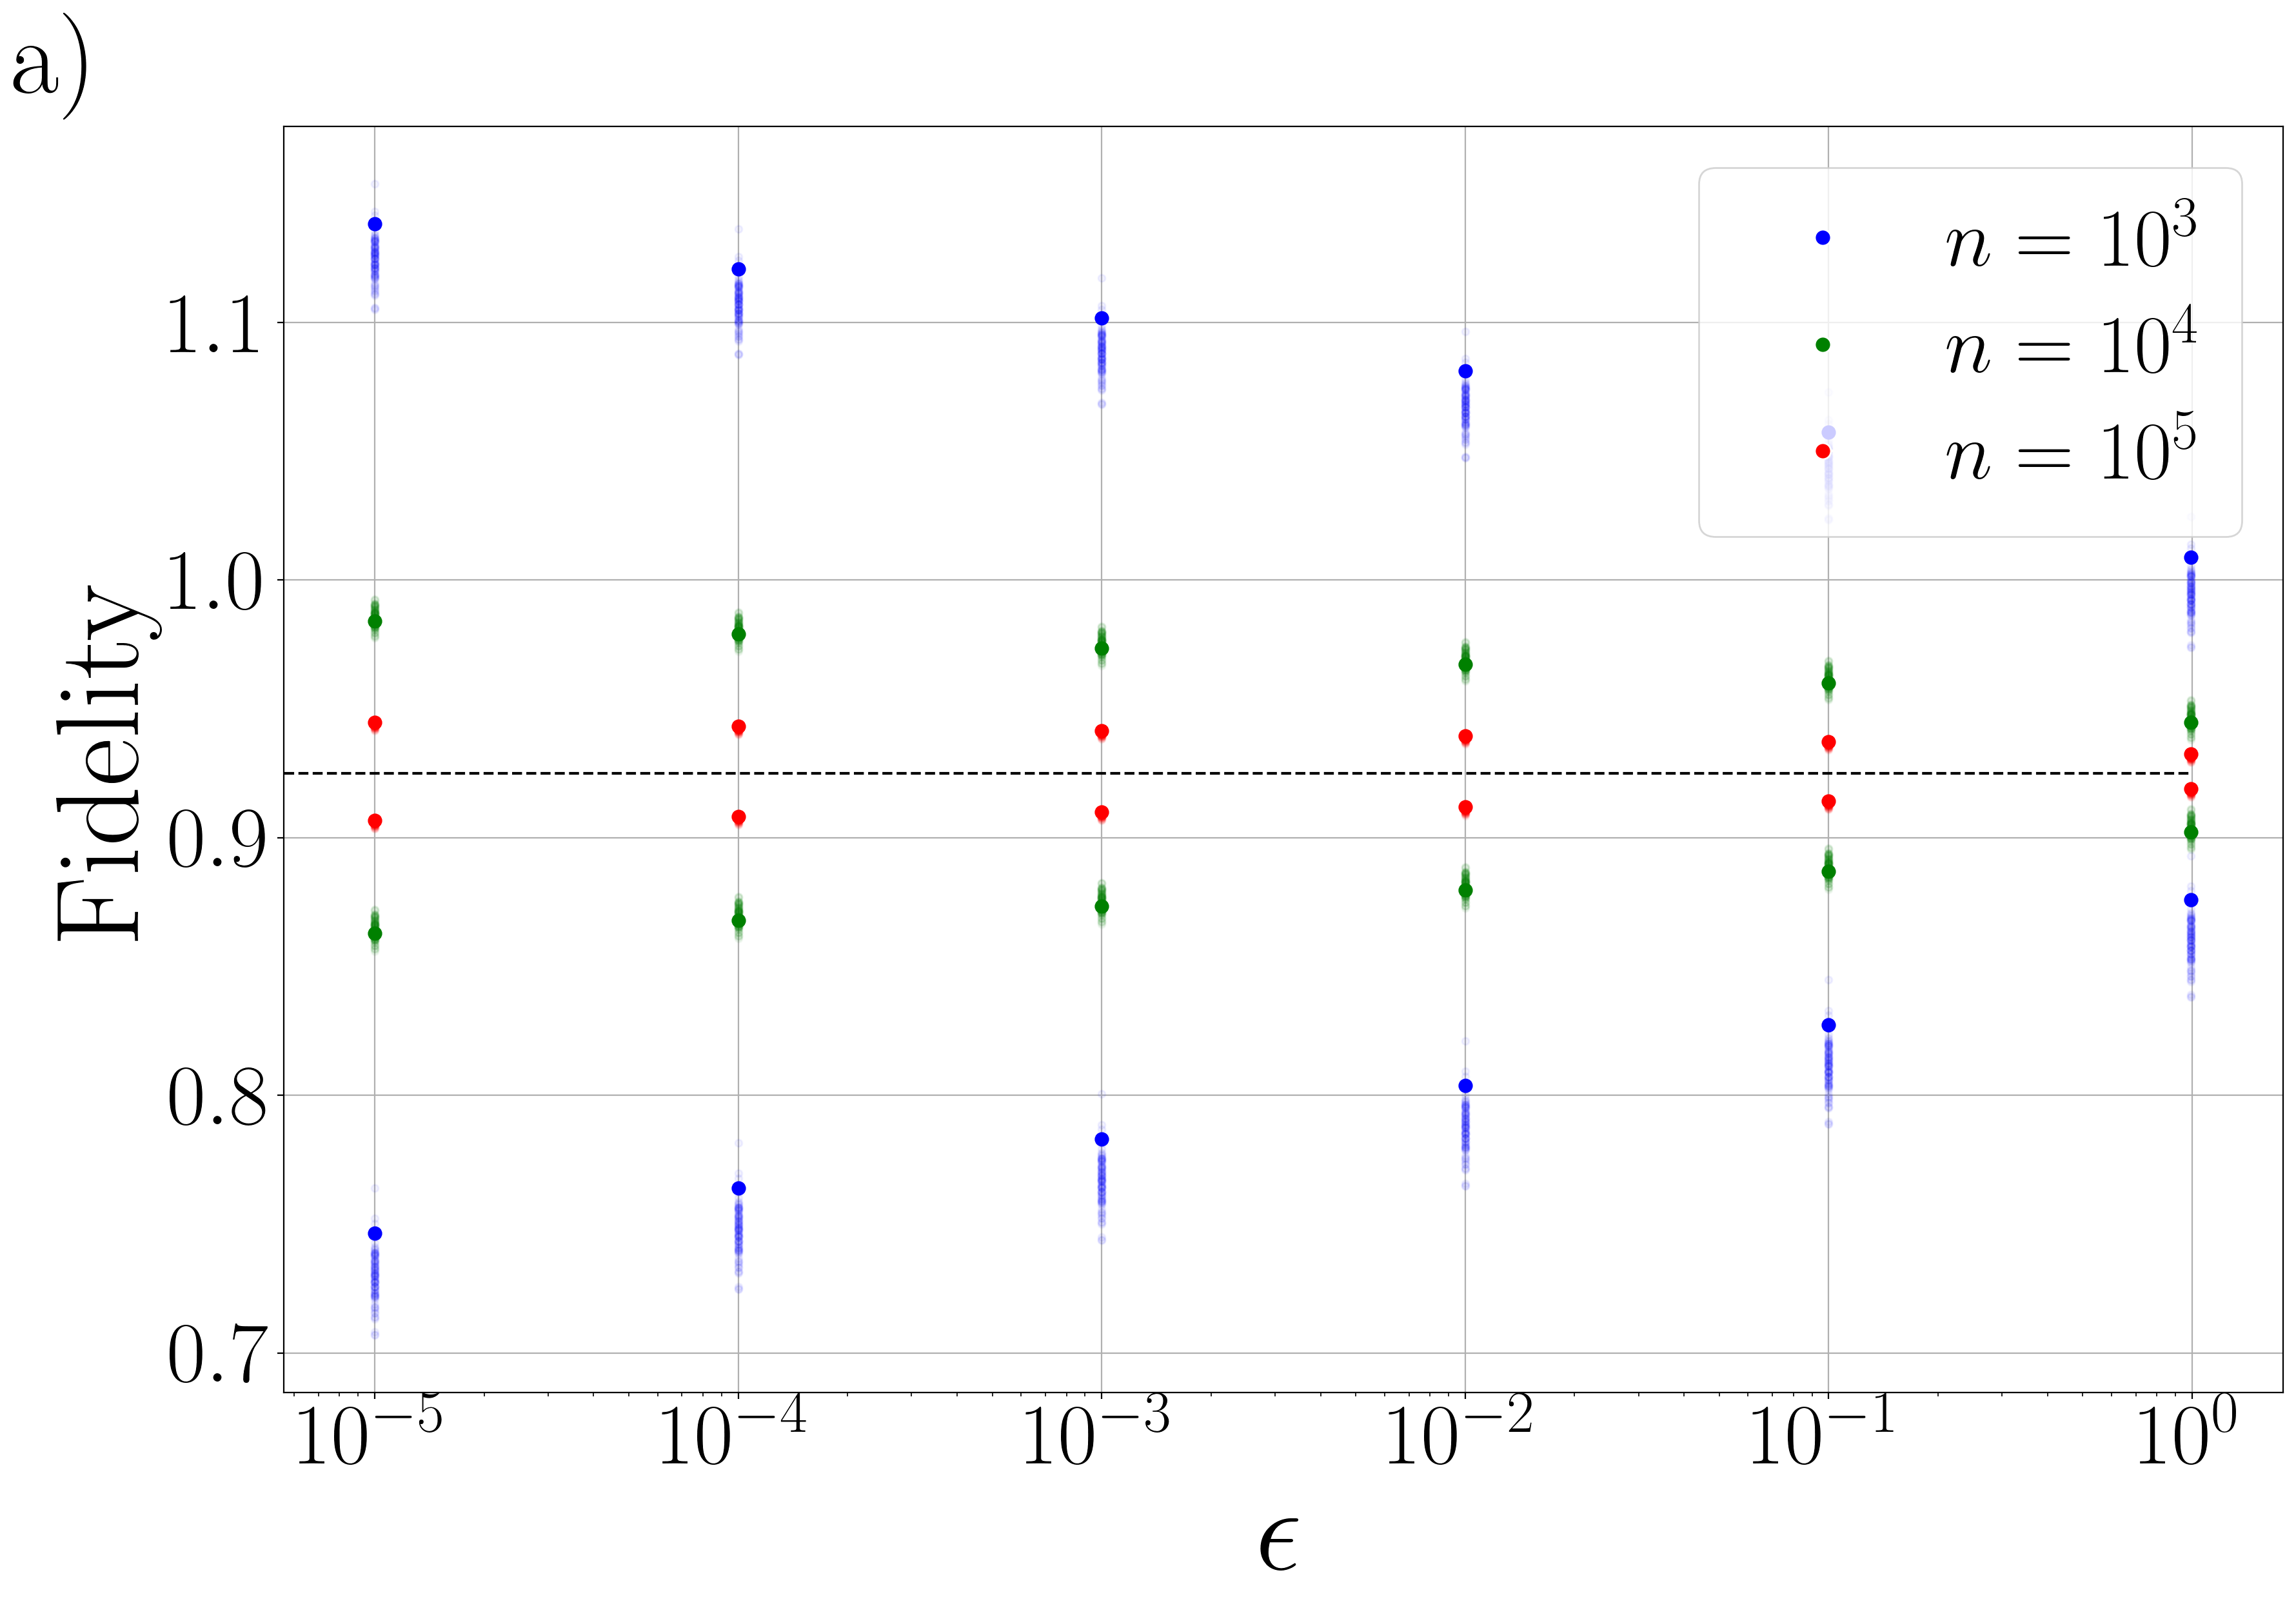

In [69]:
fmts = ['bo', 'go', 'ro']
plt.figure(figsize=(20, 13), dpi=200)
plt.grid()
plt.xlabel('$\\epsilon$')
plt.xscale('log')
plt.ylabel('Fidelity')
for min_fidelity, max_fidelity, fmt in zip(min_results, max_results, fmts):
    for epsilon, values in min_fidelity.items():
        epsilons = [epsilon] * len(values)
        plt.plot(epsilons, values, fmt, ms=4, alpha=0.05)
        plt.plot([epsilon], [values[-1]], fmt, ms=7)
    for epsilon, values in max_fidelity.items():
        epsilons = [epsilon] * len(values)
        plt.plot(epsilons, values, fmt, ms=4, alpha=0.05)
        plt.plot([epsilon], [values[-1]], fmt, ms=7)
plt.legend(handles=legend_elements)
plt.plot([0, 1], [true_fidelity] * 2, '--k')
plt.figtext(0.02, 0.9, "a)")
# plt.savefig('../imgs/polytope/fig2a.pdf')

In [14]:
min_results[0].keys()

dict_keys([1e-05, 1.614048820048266e-05, 2.6051535934991995e-05, 4.2048450836318826e-05, 6.786825245721793e-05, 0.0001095426727973103, 0.00017680722177343197, 0.00028537548767941967, 0.0004606099691596657, 0.0007434469772246267, 0.0011999597163578587, 0.0019367935642928536, 0.0031260793671239557, 0.00504564471388365, 0.008143916896826668, 0.01314467945789422, 0.021216154368926845, 0.034243908925128234, 0.05527134079444351, 0.08921064239175704, 0.14399033208816325, 0.23240742560525787, 0.37511693106862165, 0.6054570399714354, 0.9772372209558107])

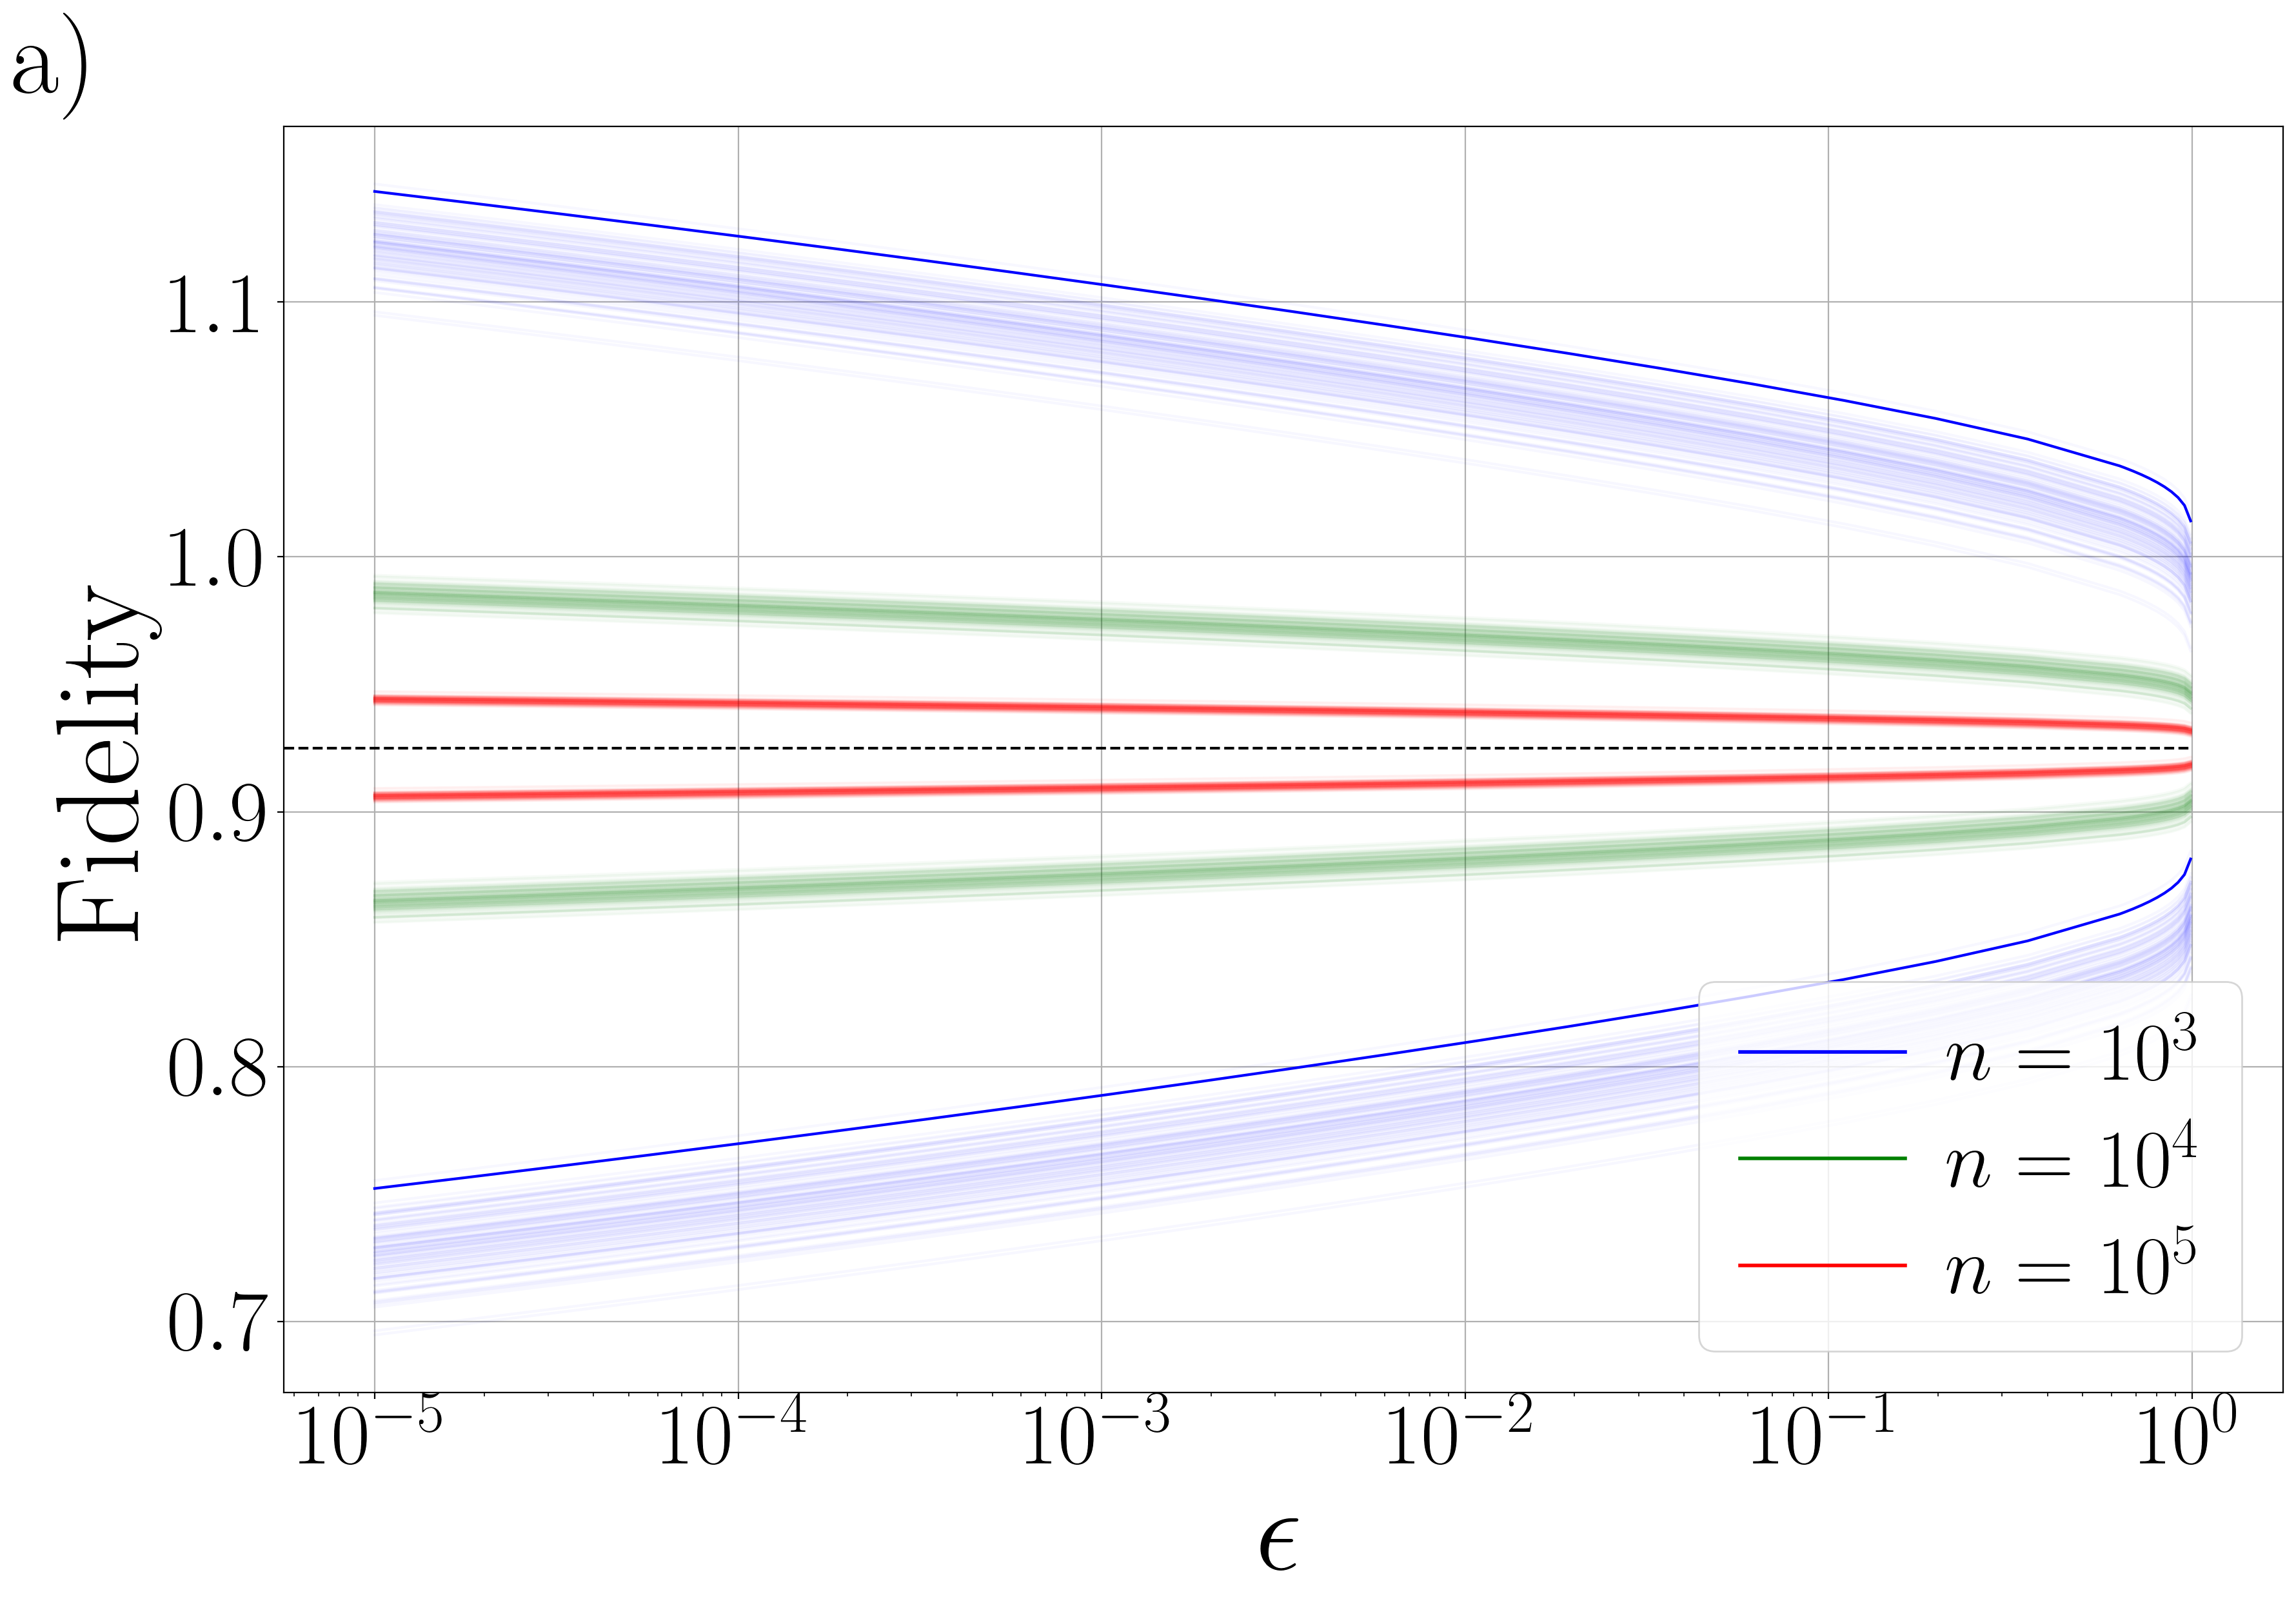

In [25]:
fmts = ['b-', 'g-', 'r-']
plt.figure(figsize=(20, 13), dpi=200)
plt.grid()
plt.xlabel('$\\epsilon$')
plt.xscale('log')
plt.ylabel('Fidelity')
for min_fidelity, max_fidelity, fmt in zip(min_results, max_results, fmts):
    epsilons = sorted(list(min_fidelity.keys()))
    for i in range(n_trials):
        minfid = [min_fidelity[epsilon][i] for epsilon in epsilons]
        maxfid = [max_fidelity[epsilon][i] for epsilon in epsilons]
        plt.plot(epsilons, minfid, fmt, alpha=0.03)
        plt.plot(epsilons, maxfid, fmt, alpha=0.03)
    if fmt == 'b-':
        minfid = [min_fidelity[epsilon][-3] for epsilon in epsilons]  # -3, -6
        maxfid = [max_fidelity[epsilon][-3] for epsilon in epsilons]
        plt.plot(epsilons, minfid, fmt, epsilons, maxfid, fmt)
plt.legend(handles=legend_elements)
plt.plot([0, 1], [true_fidelity] * 2, '--k')
plt.figtext(0.02, 0.9, "a)")
plt.savefig('../imgs/polytope/fig2a.pdf')